In [1]:
import os 

import pandas as pd
import plotly.express as px
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from plotly.subplots import make_subplots

In [3]:
pd.set_option('display.max_rows', 50000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:,.3f}'.format)

In [4]:
data = pd.read_csv('Data/fifa19.zip',compression='zip')

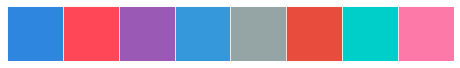

In [5]:
sns_colors = ["#2e86de", "#ff4757", "#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#00cec9", "#fd79a8"]
sns_palette = sns.color_palette(sns_colors)
sns.set_style("darkgrid")
cm = sns.light_palette("green", as_cmap=True)

sns.palplot(sns_palette)
sns.set_palette(sns_palette)

In [6]:
#Defining position
Attackers = ["LS","ST","RS",
             "LW","LF","CF",
             "RF","RW"]

Midfielders = ["LAM","CAM","RAM","LM",
               "LCM","CM","RCM","RM",
               "LDM","CDM","RDM"]

Defenders = ["LWB","RWB","LB","LCB",
             "CB","RCB","RB"]

Goalkeeper = ["GK"]

def has_digits(string):
    RE_D = re.compile('\d')
    res = RE_D.search(string)
    return res is not None

def non_decimal(string):
    if has_digits(string):
        non_decimal = re.compile(r'[^\d.]+')
        return non_decimal.sub('', string)
    return string

#TODO : Reduce this code with np.where() or mapping values
def group_by_role(df):
    poste = list()
    for val in df['Position'].str.strip():
        if val in Attackers:
            poste.append("Attackers")
        elif val in Midfielders:
            poste.append("Midfielders")
        elif val in Defenders:
            poste.append("Defenders")
        elif val in Goalkeeper:
            poste.append("Goalkeeper")
        else:
            poste.append(np.nan)
    return poste

def highlight_max(s,color):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return [f'background-color: {color}' if v else '' for v in is_max]

def non_numbers(string):
    return re.sub('\D', '', string)

def preprocessing(df):
    #Delete Unecessary column
    if 'Unnamed: 0' in df.columns:
        df.drop(['Unnamed: 0'],axis=1,inplace=True)
    #Clean and convert Value, Wage and Release clause of the players
    df['Value'] = np.where(df['Value'].str.contains('M'),
                           round(df['Value'].apply(non_decimal).astype('float64')*1000000),
                           round(df['Value'].apply(non_decimal).astype('float64')*1000))
    df['Wage'] = round(df['Wage'].apply(non_decimal).astype('float64')*1000)
    df['Release Clause'] = df['Release Clause'].fillna('Unknown')
    df['Release Clause'] = np.where(df['Release Clause'].str.contains('M'),
                                    round(pd.to_numeric(df['Release Clause'].apply(non_decimal),errors='coerce',downcast='float')*1000000),
                                    round(pd.to_numeric(df['Release Clause'].apply(non_decimal),errors='coerce')*1000))
    
    mapping = {"Medium/ Medium":'Medium','High/ Low':'HL',
               'High/ Medium':'HM',
               'High/ High':'High','Medium/ High':'MH',
               'Medium/ Low':'ML','Low/ High':'LH',
               'Low/ High':'LH','Low/ Medium':'LM',
               'Low/ Low':'Low'}
    df['Work Rate'] = df['Work Rate'].str.strip()
    df['Work Rate'] = df['Work Rate'].map(mapping)
    
    return df

def Transfo(df):
    df['Jersey Number'] = pd.to_numeric(df['Jersey Number'],errors='coerce')
    df['Loaned From'] = df['Loaned From'].fillna('Never')
    df['Work Rate'] = df['Work Rate'].fillna('Unknown')
    df['Club'] = df['Club'].fillna('Unknown')
    
    df['Contract Valid Until'] = pd.to_datetime(df['Contract Valid Until'])
    df['Joined'] = pd.to_datetime(df['Joined'])
    
    return df
    
def Create_features(df):
    df['Height_cm'] = df['Height'].str.replace("'",".")
    df['Height_cm'] = round(pd.to_numeric(df['Height_cm'],errors='coerce')*30.48)
    
    df['Weight_kg'] = df['Weight'].str.replace('lbs','')
    df['Weight_kg'] = round(pd.to_numeric(df['Weight_kg'],errors='coerce')/2.205)
    
    df['Remaining_months'] = round(((df['Contract Valid Until'] - df['Joined'])/ np.timedelta64(1, 'D'))/30)
    df['Evol_estimated'] = df['Potential']-df['Overall']
    df['Ratio_potential_evol'] = df['Evol_estimated']/df['Potential']
    df['Ratio_val_wage'] = df['Value']/df['Wage']
    df['Role'] = group_by_role(df)
    
    return df


def playerForm(df,player_name,skills_list,img_bool,img_path):
    df_player = df[df['Name']==player_name]
    df_player = df_player[skills_list].T
    df_player.columns = ['r']
    
    if img_bool:
        plt.figure(figsize=(3,3))
        img=mpimg.imread(img_path)
        imgploy = plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        fig = px.line_polar(df_player, r=df_player['r'], theta=df_player.index, line_close=True,height=580,width=600)
        fig.update_traces(fill='toself')
        fig.update_layout(title=f"{player_name} form")

    else:
        fig = px.line_polar(df_player, r=df_player['r'], theta=df_player.index, line_close=True,height=580,width=600)
        fig.update_traces(fill='toself')
        fig.update_layout(title=f"{player_name} form")
    
    fig.show()

In [7]:
dataset = data.copy()
data = preprocessing(dataset)
data = Transfo(data)
data = Create_features(data)

### Global Analysis
** Note: Don't forget that fifa 19 is a videogame, so it tends to be realistic as possible but not at all. </br> 
So it's possible to encounter false data about players like height,weight,wage...

In [8]:
data.head(10)

ID               Name  Age                                           Photo Nationality                                 Flag  Overall  Potential                 Club                                     Club Logo           Value        Wage  Special Preferred Foot  International Reputation  Weak Foot  Skill Moves Work Rate   Body Type Real Face Position  Jersey Number     Joined Loaned From Contract Valid Until Height  Weight    LS    ST    RS    LW    LF    CF    RF    RW   LAM   CAM   RAM    LM   LCM    CM   RCM    RM   LWB   LDM   CDM   RDM   RWB    LB   LCB    CB   RCB    RB  Crossing  Finishing  HeadingAccuracy  ShortPassing  Volleys  Dribbling  Curve  FKAccuracy  LongPassing  BallControl  Acceleration  SprintSpeed  Agility  Reactions  Balance  ShotPower  Jumping  Stamina  Strength  LongShots  Aggression  Interceptions  Positioning  Vision  Penalties  Composure  Marking  StandingTackle  SlidingTackle  GKDiving  GKHandling  GKKicking  GKPositioning  GKReflexes  \
0  158023           L. Messi   31  https://cdn.sofifa.org/players/4/19/158023.png   Argentina  https://cdn.sofifa.org/flags/52.png       94         94         FC Barcelona  https://cdn.sofifa.org/teams/2/light/241.png 110,500,000.000 565,000.000     2202           Left                     5.000      4.000        4.000    Medium       Messi       Yes       RF         10.000 2004-07-01       Never           2021-01-01    5'7  159lbs  88+2  88+2  88+2  92+2  93+2  93+2  93+2  92+2  93+2  93+2  93+2  91+2  84+2  84+2  84+2  91+2  64+2  61+2  61+2  61+2  64+2  59+2  47+2  47+2  47+2  59+2    84.000     95.000           70.000        90.000   86.000     97.000 93.000      94.000       87.000       96.000        91.000       86.000   91.000     95.000   95.000     85.000   68.000   72.000    59.000     94.000      48.000         22.000       94.000  94.000     75.000     96.000   33.000          28.000         26.000     6.000      11.000     15.000         14.000       8.000   
1   20801  Cristiano Ronaldo   33   https://cdn.sofifa.org/players/4/19/20801.png    Portugal  https://cdn.sofifa.org/flags/38.png       94         94             Juventus   https://cdn.sofifa.org/teams/2/light/45.png  77,000,000.000 405,000.000     2228          Right                     5.000      4.000        5.000        HL  C. Ronaldo       Yes       ST          7.000 2018-07-10       Never           2022-01-01    6'2  183lbs  91+3  91+3  91+3  89+3  90+3  90+3  90+3  89+3  88+3  88+3  88+3  88+3  81+3  81+3  81+3  88+3  65+3  61+3  61+3  61+3  65+3  61+3  53+3  53+3  53+3  61+3    84.000     94.000           89.000        81.000   87.000     88.000 81.000      76.000       77.000       94.000        89.000       91.000   87.000     96.000   70.000     95.000   95.000   88.000    79.000     93.000      63.000         29.000       95.000  82.000     85.000     95.000   28.000          31.000         23.000     7.000      11.000     15.000         14.000      11.000   
2  190871          Neymar Jr   26  https://cdn.sofifa.org/players/4/19/190871.png      Brazil  https://cdn.sofifa.org/flags/54.png       92         93  Paris Saint-Germain   https://cdn.sofifa.org/teams/2/light/73.png 118,500,000.000 290,000.000     2143          Right                     5.000      5.000        5.000        HM      Neymar       Yes       LW         10.000 2017-08-03       Never           2022-01-01    5'9  150lbs  84+3  84+3  84+3  89+3  89+3  89+3  89+3  89+3  89+3  89+3  89+3  88+3  81+3  81+3  81+3  88+3  65+3  60+3  60+3  60+3  65+3  60+3  47+3  47+3  47+3  60+3    79.000     87.000           62.000        84.000   84.000     96.000 88.000      87.000       78.000       95.000        94.000       90.000   96.000     94.000   84.000     80.000   61.000   81.000    49.000     82.000      56.000         36.000       89.000  87.000     81.000     94.000   27.000          24.000         33.000     9.000       9.000     15.000         15.000      11.000   
3  193080             De Gea   27  https://cdn.sofifa.org/p

In [9]:
#Some stats
data.describe()

ID        Age    Overall  Potential           Value        Wage    Special  International Reputation  Weak Foot  Skill Moves  Jersey Number   Crossing  Finishing  HeadingAccuracy  ShortPassing    Volleys  Dribbling      Curve  FKAccuracy  LongPassing  BallControl  Acceleration  SprintSpeed    Agility  Reactions    Balance  ShotPower    Jumping    Stamina   Strength  LongShots  Aggression  Interceptions  Positioning     Vision  Penalties  Composure    Marking  StandingTackle  SlidingTackle   GKDiving  GKHandling  GKKicking  GKPositioning  GKReflexes  Release Clause  Height_cm  Weight_kg  Remaining_months  Evol_estimated  Ratio_potential_evol  Ratio_val_wage
count  18,207.000 18,207.000 18,207.000 18,207.000      18,207.000  18,207.000 18,207.000                18,159.000 18,159.000   18,159.000     18,147.000 18,159.000 18,159.000       18,159.000    18,159.000 18,159.000 18,159.000 18,159.000  18,159.000   18,159.000   18,159.000    18,159.000   18,159.000 18,159.000 18,159.000 18,159.000 18,159.000 18,159.000 18,159.000 18,159.000 18,159.000  18,159.000     18,159.000   18,159.000 18,159.000 18,159.000 18,159.000 18,159.000      18,159.000     18,159.000 18,159.000  18,159.000 18,159.000     18,159.000  18,159.000      16,643.000 18,159.000 18,159.000        16,654.000      18,207.000            18,207.000      17,966.000
mean  214,298.339     25.122     66.239     71.307   2,410,695.886   9,731.312  1,597.810                     1.113      2.947        2.361         19.546     49.734     45.551           52.298        58.687     42.909     55.371     47.171      42.863       52.712       58.369        64.614       64.727     63.504     61.837     63.967     55.460     65.089     63.220     65.312     47.110      55.869         46.698       49.958     53.401     48.549     58.648     47.282          47.698         45.661     16.616      16.392     16.232         16.389      16.711   4,585,060.988    176.748     75.289            40.982           5.069                 0.070         333.433
std    29,965.244      4.670      6.909      6.136   5,594,932.671  21,999.290    272.586                     0.394      0.660        0.756         15.948     18.365     19.526           17.380        14.699     17.694     18.910     18.395      17.479       15.328       16.687        14.928       14.650     14.766      9.010     14.136     17.238     11.820     15.895     12.557     19.261      17.368         20.697       19.529     14.147     15.704     11.436     19.904          21.664         21.289     17.695      16.907     16.503         17.035      17.955  11,118,717.769     13.716      7.076            29.233           5.417                 0.074         756.923
min        16.000     16.000     46.000     48.000           0.000       0.000    731.000                     1.000      1.000        1.000          1.000      5.000      2.000            4.000         7.000      4.000      4.000      6.000       3.000        9.000        5.000        12.000       12.000     14.000     21.000     16.000      2.000     15.000     12.000     17.000      3.000      11.000          3.000        2.000     10.000      5.000      3.000      3.000           2.000          3.000      1.000       1.000      1.000          1.000       1.000      13,000.000    155.000     50.000           -11.000           0.000                 0.000           0.000
25%   200,315.500     21.000     62.000     67.000     300,000.000   1,000.000  1,457.000                     1.000      3.000        2.000          8.000     38.000     30.000           44.000        54.000     30.000     49.000     34.000      31.000       43.000       54.000        57.000       57.000     55.000     56.000     56.000     45.000     58.000     56.000     58.000     33.000      44.000         26.000       38.000     44.000     39.000     51.000     30.000          27.000         24.000      8.000       8.000      8.000          8.000       8.000     525,000.000    156.000     70.000        

In [10]:
#NA values
null_count_df = pd.DataFrame(data.isnull().sum(),columns=['Count'])
null_count_df = null_count_df.query("Count>0")
cm = sns.light_palette("green", as_cmap=True)
null_count_df.style.background_gradient(cmap=cm)

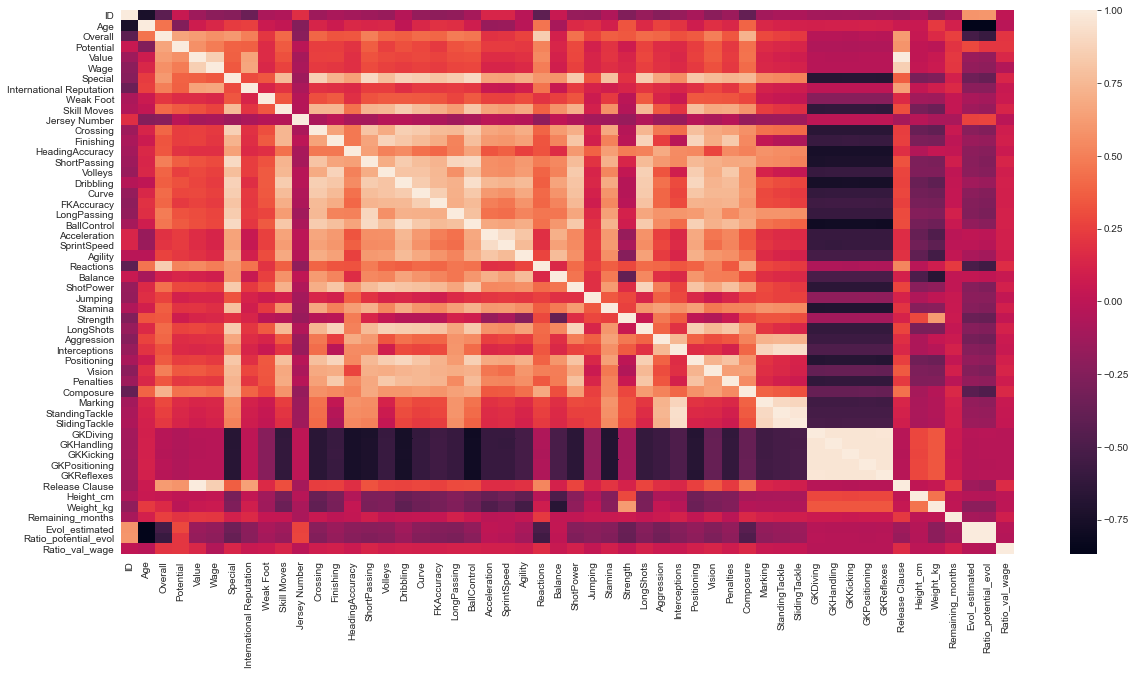

In [11]:
plt.figure(figsize=(20,10))
sns.heatmap(data.corr())

In [12]:
#Top 10 players who earns the most
#7/10 players comes from Liga 
wage_df = data[['Name','Age','Overall','Wage','Club','Photo']].sort_values('Wage',ascending=False).head(10)
wage_df.style.apply(highlight_max, subset=['Age', 'Overall', 'Wage'],color='darkorange')

Text(0.5, 1.0, 'Top 10 player wages')

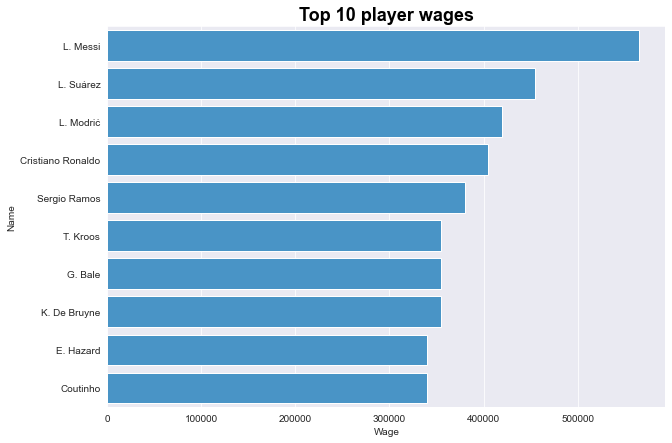

In [13]:
#Unfortunetly the image players link don't exists so i couldn't display it near to the name players (sofifa change url)
#import requests
#from PIL import Image
#from matplotlib.offsetbox import OffsetImage, AnnotationBbox
#from io import BytesIO
fig, ax = plt.subplots(figsize=(10, 7))

sns.barplot(x='Wage', y='Name',orient='h', data=wage_df,
            color=sns_palette[3])

#for pos, i in enumerate(wage_df.index):
#    request = requests.get(wage_df.loc[i, 'Photo'])
#    player_faces = Image.open(BytesIO(request.content))
#    oi = OffsetImage(player_faces, zoom=0.)
#    box = AnnotationBbox(oi, (3500, pos-0.48), frameon=False, box_alignment=(0.5, 1))
#    ax.add_artist(box)
plt.title("Top 10 player wages", fontsize=18, fontweight='bold', color='black')

In [14]:
#Top 10 players value
value_df = data[['Name','Value','Age','Overall']].sort_values('Value',ascending=False).head(10)
value_df.style.apply(highlight_max, subset=['Age', 'Overall', 'Value'],color='darkorange')

Text(0.5, 1.0, 'Top 10 player Value')

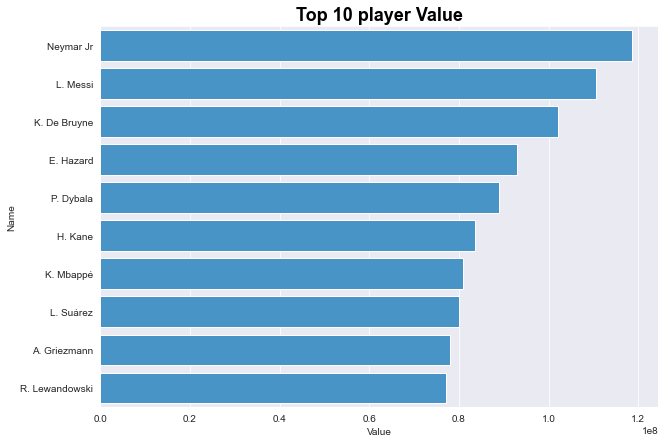

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.barplot(x='Value', y='Name',orient='h', data=value_df,
            color=sns_palette[3])
plt.title("Top 10 player Value", fontsize=18, fontweight='bold', color='black')

In [16]:
#Top 10 players value
potential_df = data[['Name','Potential','Age','Evol_estimated','Value']].sort_values('Potential',ascending=False).head(10)
potential_df.style.apply(highlight_max, subset=['Age', 'Potential', 'Evol_estimated','Value'],color='darkorange')

Text(0.5, 1.0, 'Top 10 player potential')

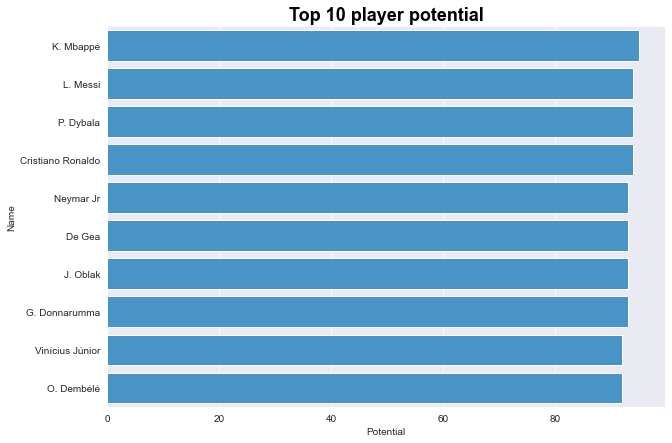

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.barplot(x='Potential', y='Name',orient='h', data=potential_df,
            color=sns_palette[3])
plt.title("Top 10 player potential", fontsize=18, fontweight='bold', color='black')

In [18]:
#Top 10 players evol_estimated
evol_df = data[['Name','Potential','Age','Evol_estimated','Value']].sort_values('Evol_estimated',ascending=False).head(10)
evol_df.style.apply(highlight_max, subset=['Age', 'Potential', 'Evol_estimated','Value'],color='darkorange')

Text(0.5, 1.0, 'Top 10 player evol_estimated')

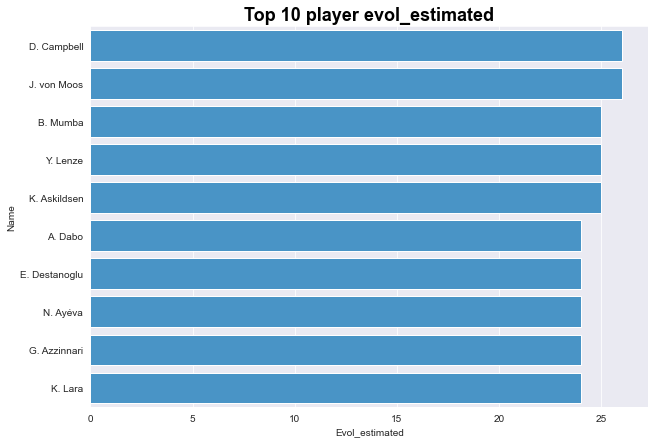

In [19]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.barplot(x='Evol_estimated', y='Name',orient='h', data=evol_df,
            color=sns_palette[3])
plt.title("Top 10 player evol_estimated", fontsize=18, fontweight='bold', color='black')

Text(0.5, 1.0, 'Value vs Wage')

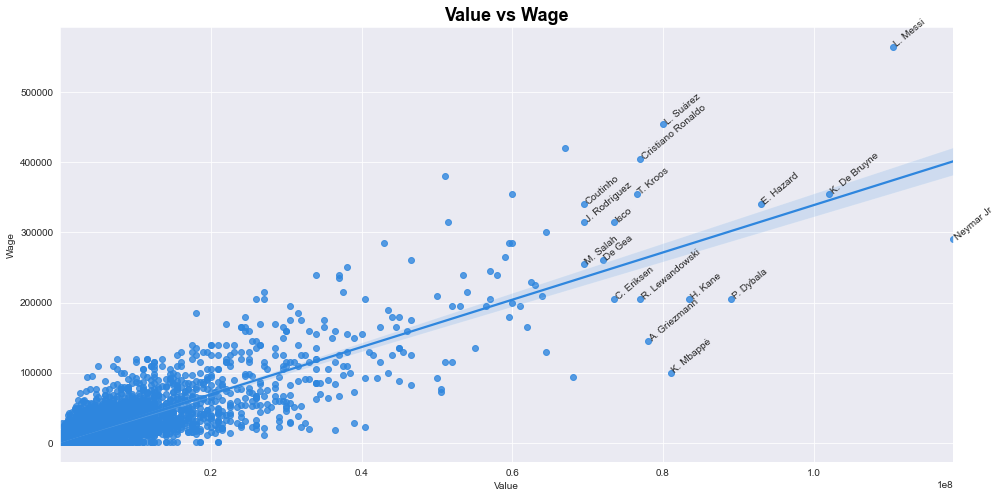

In [20]:
#Link between Value and Wage
#With plotly you could see each point player
#Messi has the best wage/value on fifa
fig, ax = plt.subplots(figsize=(16, 8))

value_wage = data.loc[data['Value'] > 0]
value_annot_cond = data.loc[data['Value'] > 68000000]

sns.regplot('Value', 'Wage',
            data=value_wage)

for i in value_annot_cond.index:
    ax.annotate(value_annot_cond.loc[i, 'Name'],
                (value_annot_cond.loc[i, 'Value'], value_annot_cond.loc[i, 'Wage'])
                ,rotation=40)

plt.title("Value vs Wage", fontsize=18, fontweight='bold', color='black')

Text(0.5, 1.0, 'Evol_estimated vs Overall')

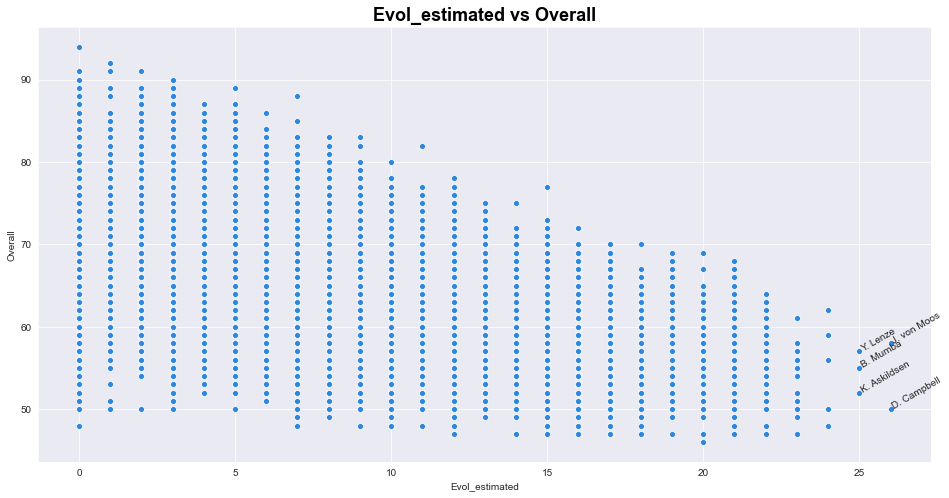

In [21]:
#Link between Potential and Evol_estimated
fig, ax = plt.subplots(figsize=(16, 8))

weight_annot = data.loc[data['Evol_estimated'] >24]

sns.scatterplot('Evol_estimated', 'Overall',
            data=data)

for i in weight_annot.index:
    ax.annotate(weight_annot.loc[i, 'Name'],
                (weight_annot.loc[i, 'Evol_estimated'], weight_annot.loc[i, 'Overall'])
                ,rotation=30)

plt.title("Evol_estimated vs Overall", fontsize=18, fontweight='bold', color='black')

Text(0.5, 1.0, 'Height vs Weight')

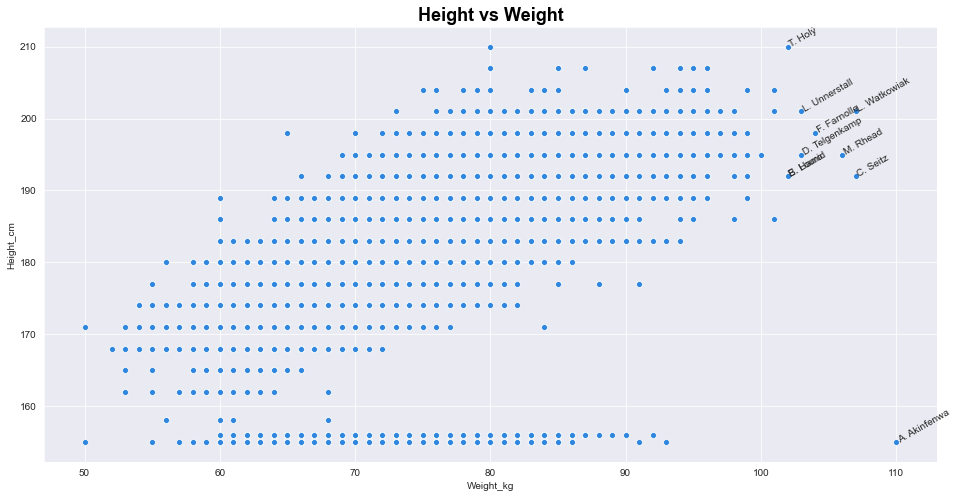

In [22]:
#Link between Value and Wage
#With plotly you could see each point player
#It's logicaly Akinfewa the beast the biggest player
#We can see a lot of player with the same height (1.55cm i think it's kind a default value)
fig, ax = plt.subplots(figsize=(16, 8))

weight_annot = data.loc[data['Weight_kg'] > 101]

sns.scatterplot('Weight_kg', 'Height_cm',
            data=data)

for i in weight_annot.index:
    ax.annotate(weight_annot.loc[i, 'Name'],
                (weight_annot.loc[i, 'Weight_kg'], weight_annot.loc[i, 'Height_cm'])
                ,rotation=30)

plt.title("Height vs Weight", fontsize=18, fontweight='bold', color='black')

Text(0.5, 1.0, 'Jersey Number vs Age')

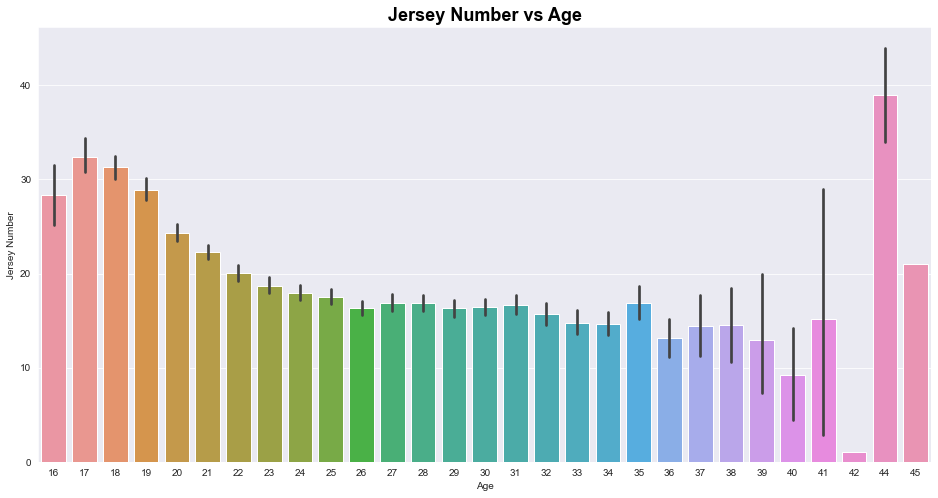

In [23]:
#Link between Number Jersey and Age
#Fun fact : The younger players in fifa (link in reality) don't has choice in a large gap of number so they take the bigger ones generaly
#35-45y (Gk, player not well-know or real choice)
fig, ax = plt.subplots(figsize=(16, 8))

sns.barplot('Age', 'Jersey Number',
            data=data)

plt.title("Jersey Number vs Age", fontsize=18, fontweight='bold', color='black')

Text(0.5, 1.0, 'Age vs Overall')

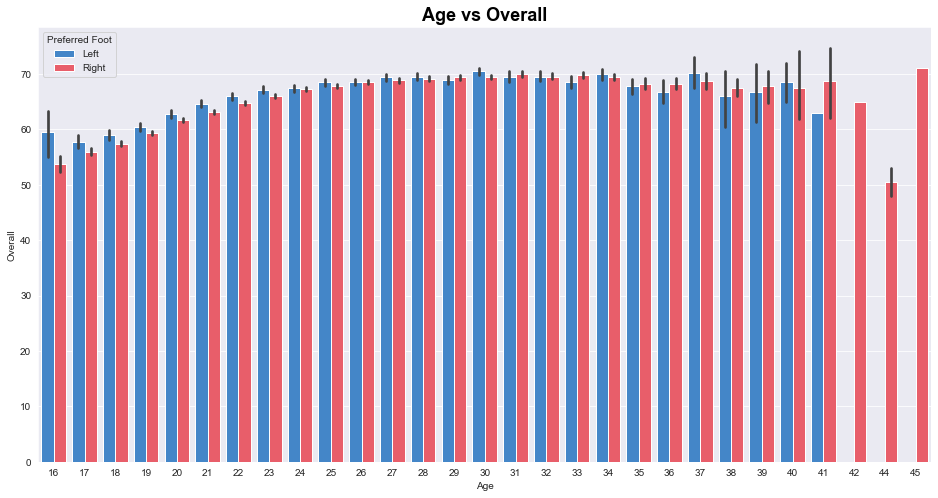

In [24]:
#the left foot players seems to have a better overall value than the right foot player
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot('Age','Overall',data=data,hue='Preferred Foot')
plt.title("Age vs Overall", fontsize=18, fontweight='bold', color='black')

#### More global stats to come ...

### Clubs stats

In [25]:
#Sort by the most valuable clubs
Club_df = data.groupby('Club').agg(Count_nationality=('Nationality','nunique'),
                                      Overall_mean=('Overall','mean'),
                                      Evol_estimated=('Evol_estimated','mean'),
                                      Potential=('Potential','mean'),
                                      Age_mean=('Age','mean'),
                                      Left_foot=("Preferred Foot",lambda val: (val == 'Left').sum()),
                                      Right_foot=("Preferred Foot",lambda val: (val == 'Right').sum()),
                                      Values=('Value','sum'),
                                      Wages =('Wage','sum'),
                                      Internation_rep=('International Reputation','mean'),
                                      Count_Attackers=('Role',lambda val: (val == 'Attackers').sum()),
                                      Count_Midfielders=('Role',lambda val: (val == 'Midfielders').sum()),
                                      Count_Defenders=('Role',lambda val: (val == 'Defenders').sum()),
                                      Count_Goalkeeper=('Role',lambda val: (val == 'Goalkeeper').sum())
                                      ).sort_values('Values',ascending=False)

In [26]:
Club_df.head(15)

Count_nationality  Overall_mean  Evol_estimated  Potential  Age_mean  Left_foot  Right_foot          Values         Wages  Internation_rep  Count_Attackers  Count_Midfielders  Count_Defenders  Count_Goalkeeper
Club                                                                                                                                                                                                                                  
Real Madrid                         11        78.242           6.394     84.636    24.030          6          27 874,425,000.000 5,017,000.000            2.091               10                  7               12                 4
FC Barcelona                        12        78.030           7.273     85.303    23.848         12          21 852,600,000.000 4,837,000.000            2.242                8                 10               11                 4
Manchester City                     13        76.727           7.182     83.909    23.909         12          21 786,555,000.000 3,741,000.000            2.091                8                  8               13                 4
Juventus                            12        82.280           3.240     85.520    27.160          8          17 704,475,000.000 3,292,000.000            2.520                4                  9                9                 3
FC Bayern München                    9        77.000           6.655     83.655    24.310          6          23 679,025,000.000 2,286,000.000            2.517                2                 15                8                 4
Atlético Madrid                     11        75.061           7.394     82.455    23.758          9          24 644,525,000.000 1,533,000.000            1.879                6                 13               11                 3
Paris Saint-Germain                 10        77.433           6.133     83.567    24.567          9          21 625,325,000.000 2,161,000.000            2.233                4                 13               10                 3
Tottenham Hotspur                   14        76.697           5.364     82.061    24.606         10          23 618,450,000.000 2,623,000.000            2.000                5                 15                9                 4
Chelsea                             15        76.788           5.848     82.636    25.212          4          29 606,815,000.000 3,249,000.000            2.121                9                 11                9                 4
Manchester United                   16        77.242           5.424     82.667    24.758          9          24 588,850,000.000 3,391,000.000            2.091                6                 13               11                 3
Liverpool                           15        76.000           6.394     82.394    24.000          6          27 585,055,000.000 2,902,000.000            1.970                5                 16                9                 3
Napoli                              18        80.000           3.440     83.440    25.920          8          17 514,000,000.000 1,777,000.000            2.160                6                  7                9                 3
Inter                               13        79.750           2.000     81.750    27.458          4          20 466,485,000.000 1,596,000.000            2.167                2                 10                8                 4
Arsenal                             16        75.182           6.212     81.394    24.606          6          27 435,990,000.000 2,588,000.000            2.030                4                 12               14                 3
Borussia Dortmund                   15        75.333           7.061     82.394    23.091         10          23 420,245,000.000 1,258,000.000            2.000                4                 18                8                 3

<Figure size 1800x1080 with 0 Axes>

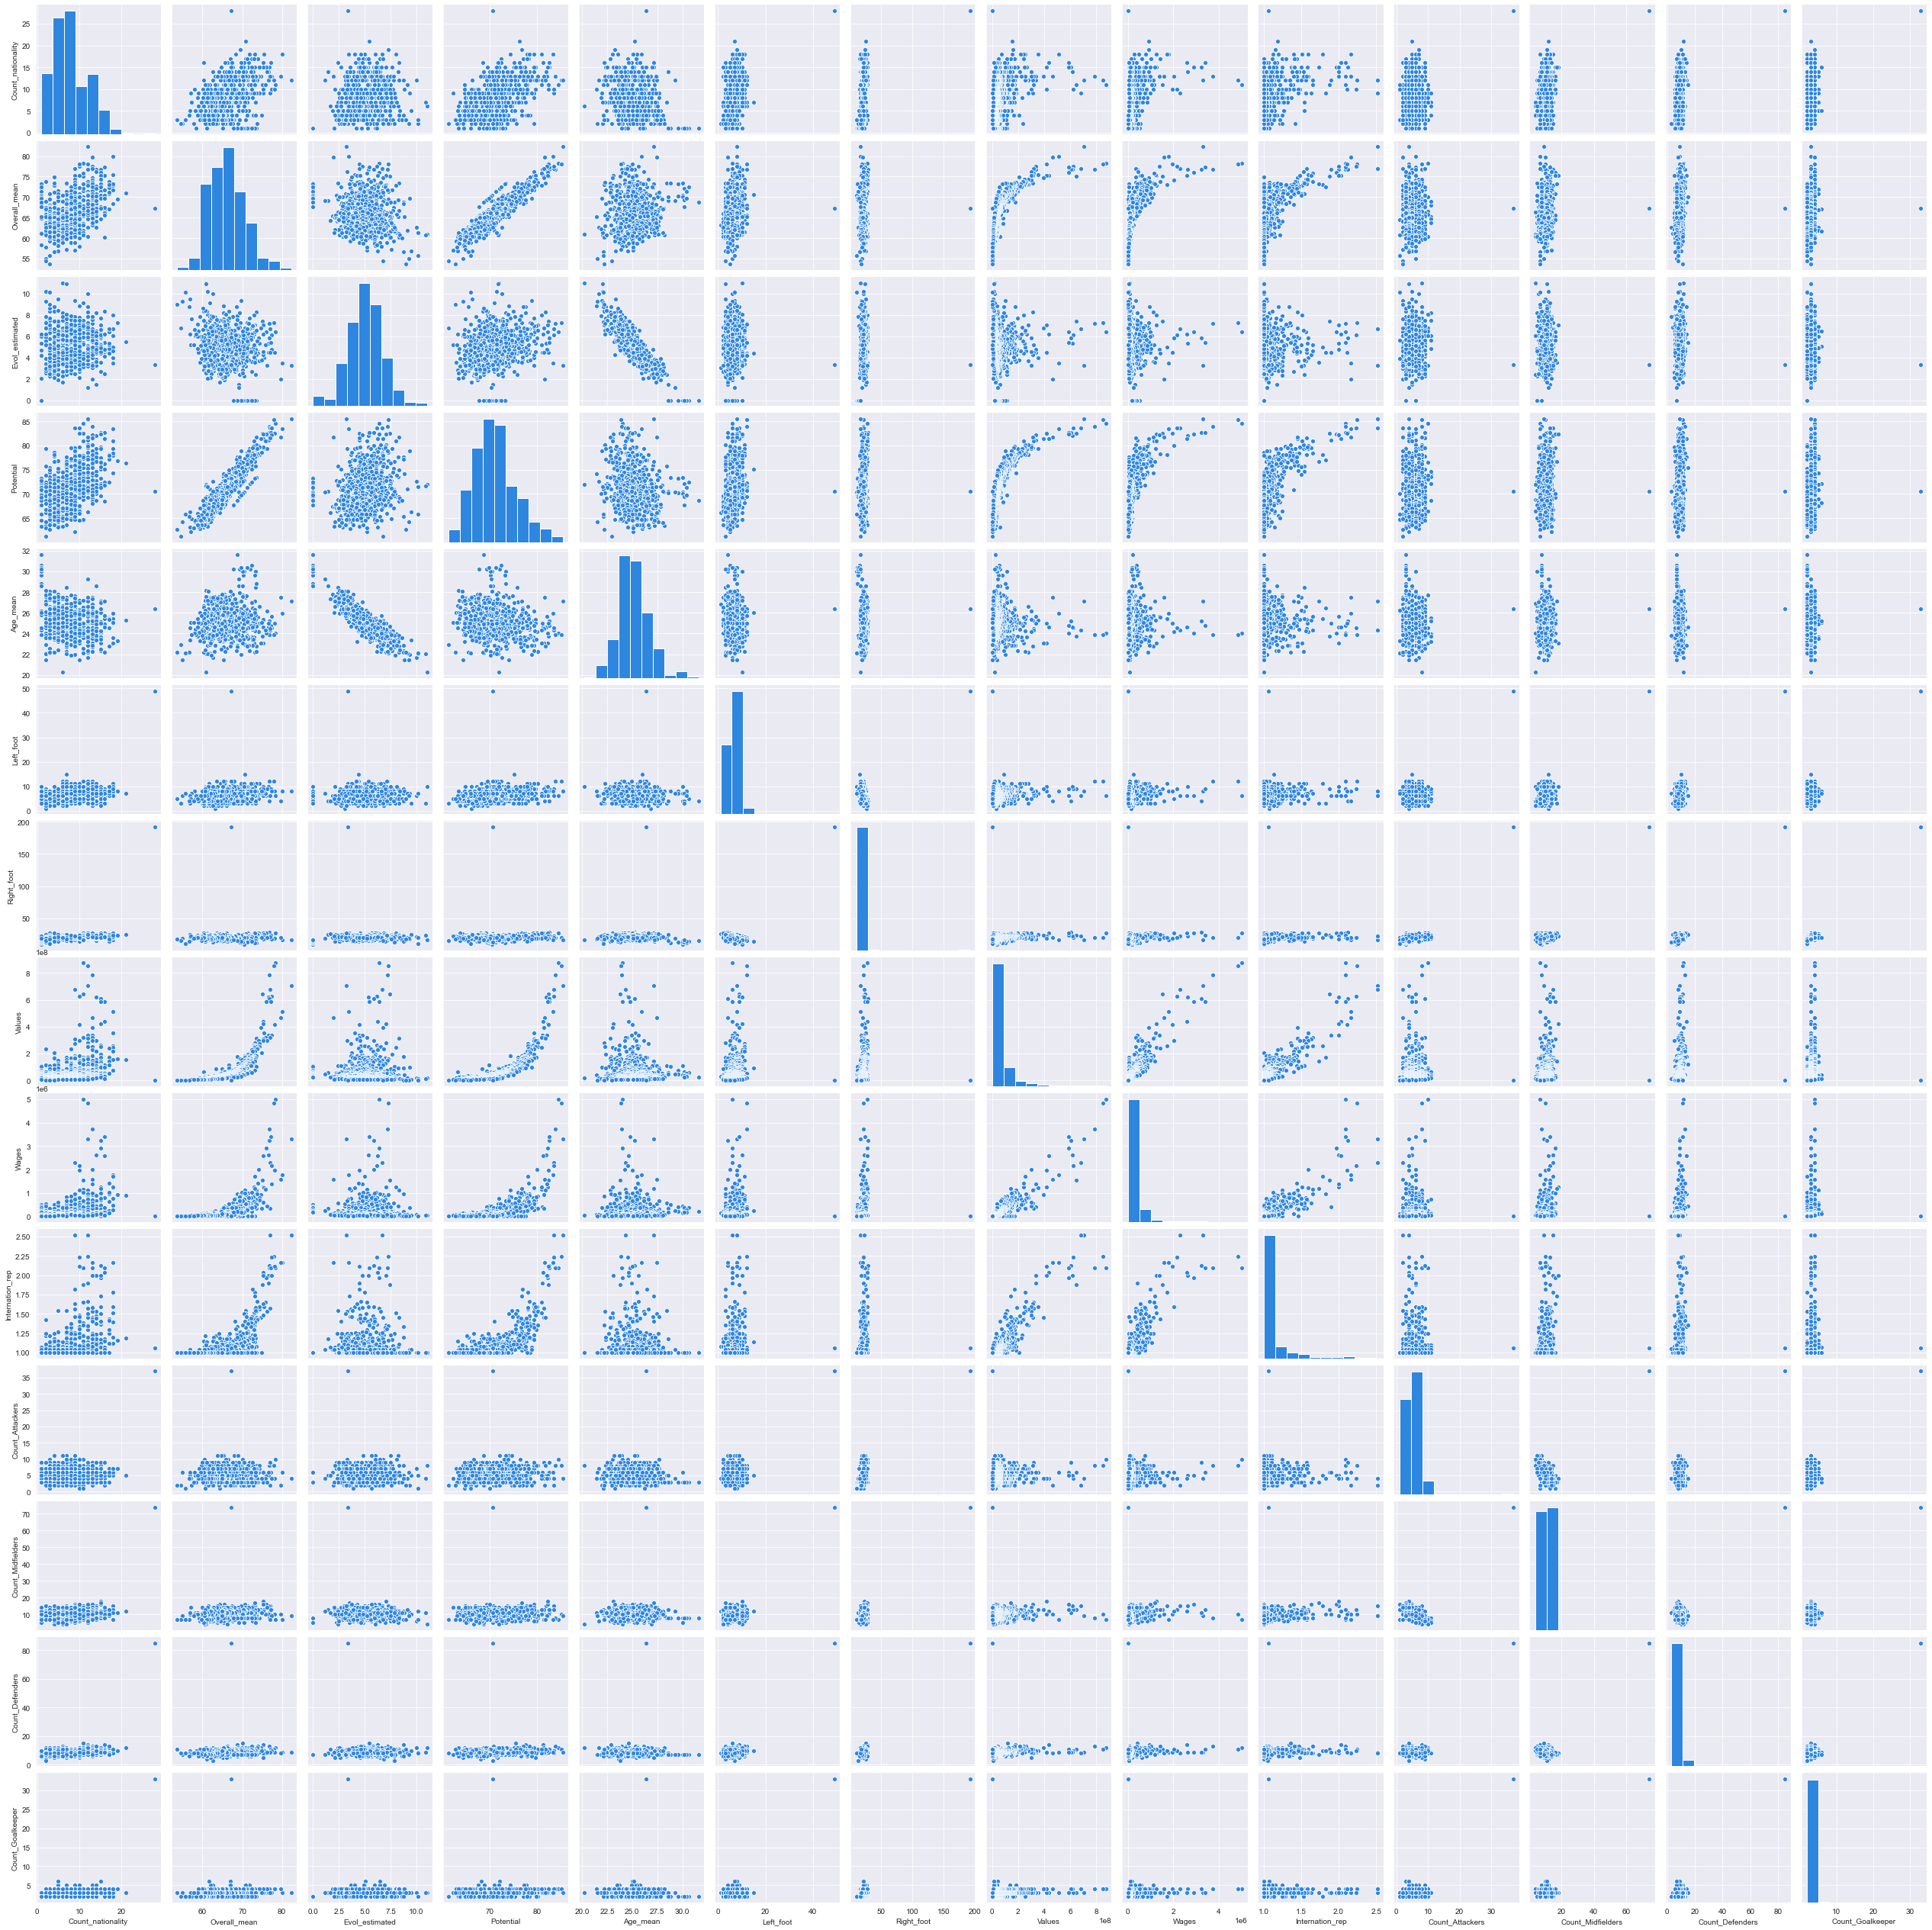

In [27]:
plt.figure(figsize=(25,15))
sns.pairplot(Club_df)

In [28]:
col = ['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']

##### More club stats to come ...

### Now it's time to analyze the biggest club ever (LOL) ... ARSENAL

In [29]:
Arsenal = data[data['Club'].str.contains('Arsenal')].sort_values("Overall",ascending=False)

In [30]:
Arsenal.head(10)

ID           Name  Age                                           Photo Nationality                                  Flag  Overall  Potential     Club                                   Club Logo          Value        Wage  Special Preferred Foot  International Reputation  Weak Foot  Skill Moves Work Rate Body Type Real Face Position  Jersey Number     Joined Loaned From Contract Valid Until Height  Weight    LS    ST    RS    LW    LF    CF    RF    RW   LAM   CAM   RAM    LM   LCM    CM   RCM    RM   LWB   LDM   CDM   RDM   RWB    LB   LCB    CB   RCB    RB  Crossing  Finishing  HeadingAccuracy  ShortPassing  Volleys  Dribbling  Curve  FKAccuracy  LongPassing  BallControl  Acceleration  SprintSpeed  Agility  Reactions  Balance  ShotPower  Jumping  Stamina  Strength  LongShots  Aggression  Interceptions  Positioning  Vision  Penalties  Composure  Marking  StandingTackle  SlidingTackle  GKDiving  GKHandling  GKKicking  GKPositioning  GKReflexes  Release Clause  Height_cm  \
33   188567  P. Aubameyang   29  https://cdn.sofifa.org/players/4/19/188567.png       Gabon  https://cdn.sofifa.org/flags/115.png       88         88  Arsenal  https://cdn.sofifa.org/teams/2/light/1.png 59,000,000.000 265,000.000     2069          Right                     3.000      4.000        4.000        ML      Lean       Yes       LM         14.000 2018-01-31       Never           2021-01-01    6'2  176lbs  84+3  84+3  84+3  83+3  83+3  83+3  83+3  83+3  81+3  81+3  81+3  81+3  73+3  73+3  73+3  81+3  64+3  58+3  58+3  58+3  64+3  61+3  52+3  52+3  52+3  61+3    77.000     88.000           79.000        77.000   86.000     79.000 80.000      74.000       64.000       82.000        93.000       95.000   76.000     87.000   70.000     82.000   79.000   76.000    76.000     79.000      43.000         48.000       90.000  77.000     76.000     86.000   27.000          25.000         36.000     6.000       9.000     15.000          9.000       9.000 112,100,000.000    189.000   
74   176635        M. Özil   29  https://cdn.sofifa.org/players/4/19/176635.png     Germany   https://cdn.sofifa.org/flags/21.png       86         86  Arsenal  https://cdn.sofifa.org/teams/2/light/1.png 43,500,000.000 190,000.000     1911           Left                     4.000      2.000        4.000        ML      Lean       Yes      CAM         10.000 2013-09-02       Never           2021-01-01   5'11  168lbs  75+3  75+3  75+3  82+3  81+3  81+3  81+3  82+3  84+3  84+3  84+3  82+3  78+3  78+3  78+3  82+3  57+3  56+3  56+3  56+3  57+3  52+3  40+3  40+3  40+3  52+3    83.000     73.000           54.000        89.000   80.000     84.000 84.000      77.000       82.000       90.000        72.000       69.000   79.000     84.000   70.000     70.000   48.000   69.000    57.000     75.000      48.000         24.000       83.000  91.000     67.000     82.000   24.000          16.000         19.000     6.000      14.000     10.000          6.000      14.000  82,700,000.000    156.000   
87   193301   A. Lacazette   27  https://cdn.sofifa.org/players/4/19/193301.png      France   https://cdn.sofifa.org/flags/18.png       85         86  Arsenal  https://cdn.sofifa.org/teams/2/light/1.png 45,000,000.000 180,000.000     2060          Right                     3.000      4.000        4.000      High    Normal       Yes       ST          9.000 2017-07-05       Never           2022-01-01    5'9  161lbs  82+3  82+3  82+3  81+3  83+3  83+3  83+3  81+3  81+3  81+3  81+3  79+3  74+3  74+3  74+3  79+3  62+3  60+3  60+3  60+3  62+3  59+3  54+3  54+3  54+3  59+3    64.000     88.000           73.000        80.000   81.000     85.000 74.000      71.000       59.000       83.000        81.000       84.000   85.000     85.000   85.000     83.000   76.000   79.000    73.000     75.000      70.000         42.000       86.000  76.000     84.000     85.000   29.000          42.000         30.000    11.000       6.000      9.000          5.000       6.000  88,900,000.000    180.000   
131  192563        B. Len

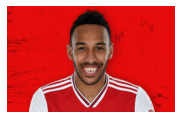

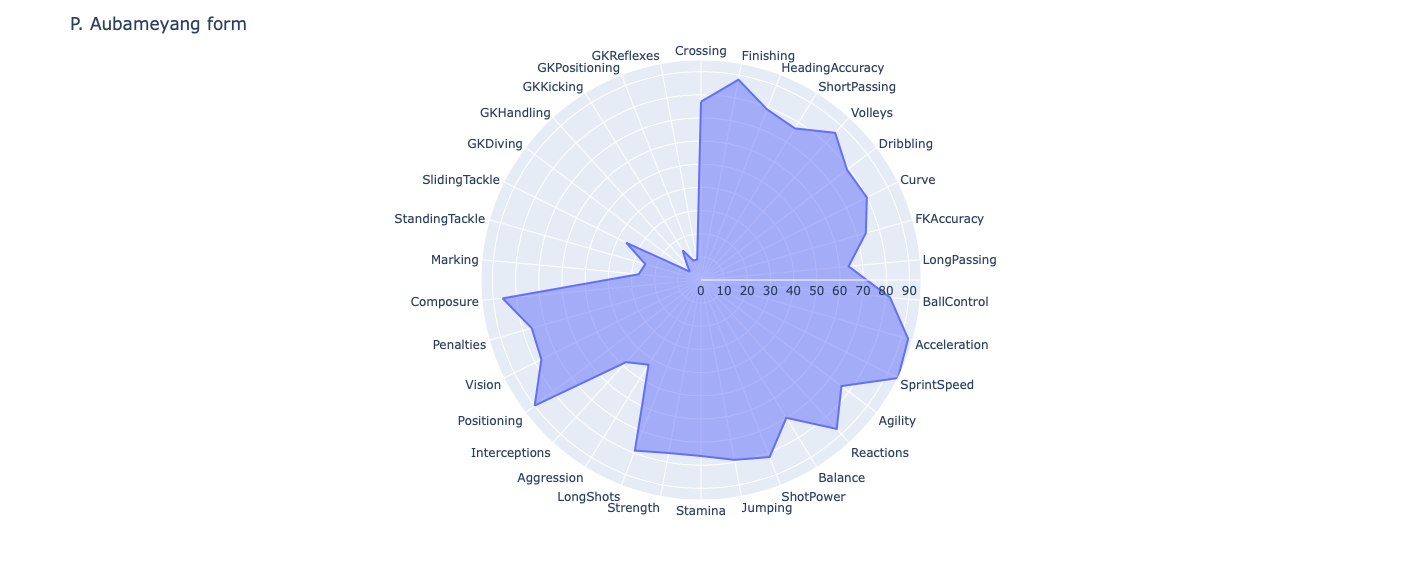

In [31]:
player_name = 'P. Aubameyang'
skills_list = col
path = 'Data/Arsenal_players/aubameyang.jpg'
playerForm(df=Arsenal,player_name=player_name,
           skills_list=skills_list,img_bool=True,img_path=path)

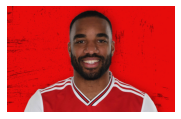

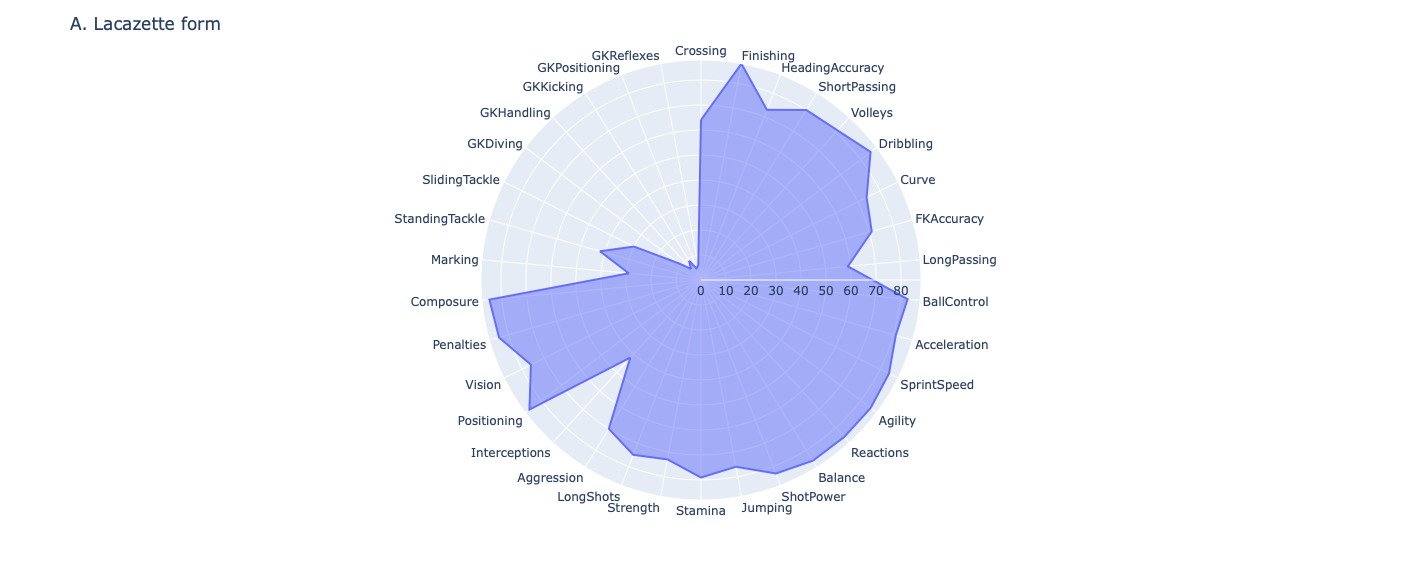

In [32]:
player_name = 'A. Lacazette'
skills_list = col
path = 'Data/Arsenal_players/laca.jpg'
playerForm(df=Arsenal,player_name=player_name,
           skills_list=skills_list,img_bool=True,img_path=path)

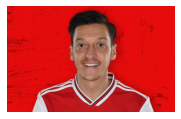

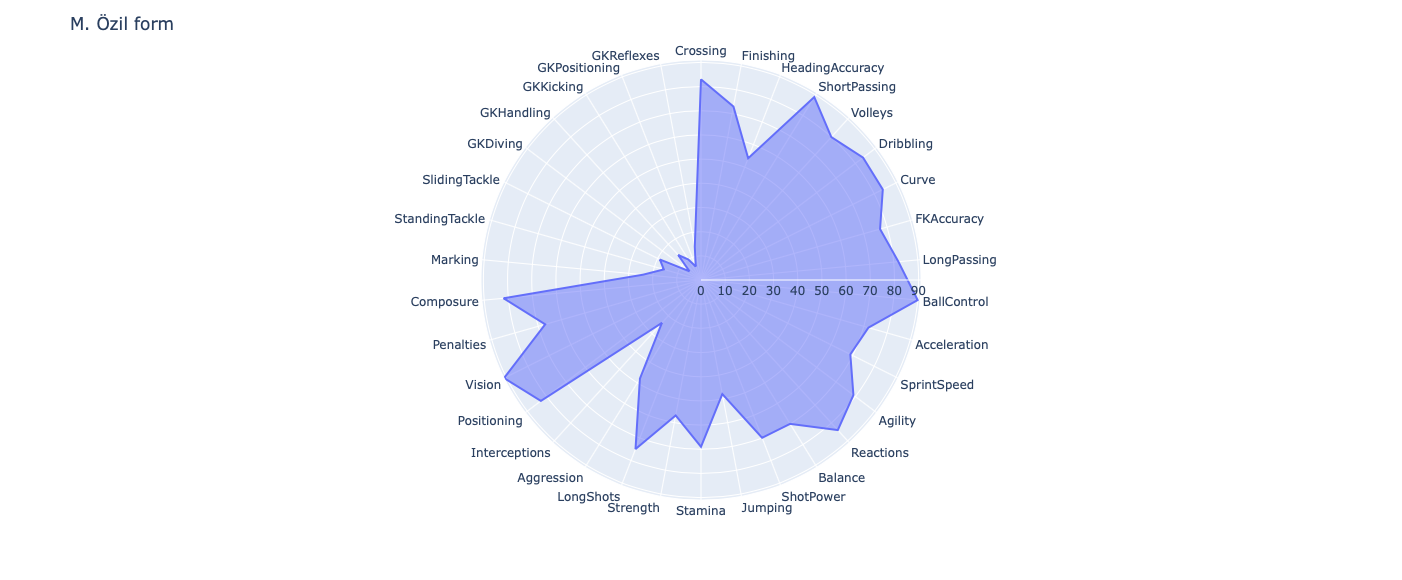

In [33]:
player_name = 'M. Özil'
skills_list = col
path = 'Data/Arsenal_players/ozil.jpg'
playerForm(df=Arsenal,player_name=player_name,
           skills_list=skills_list,img_bool=True,img_path=path)

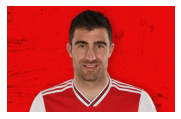

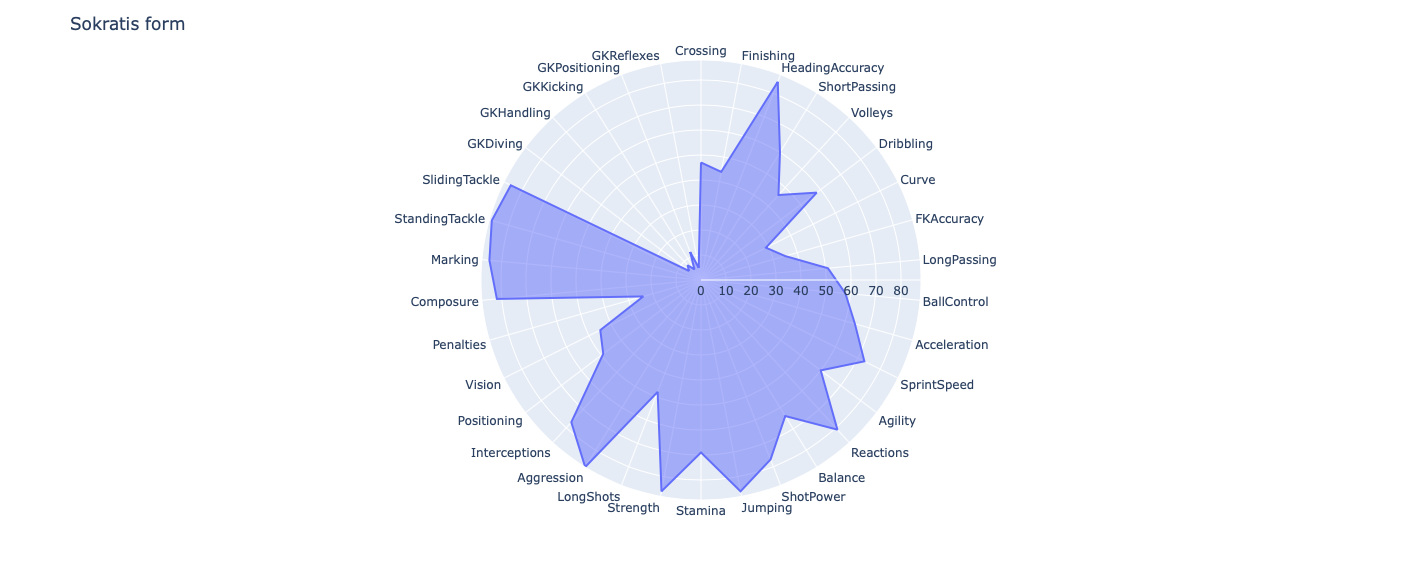

In [34]:
player_name = 'Sokratis'
skills_list = col
path = 'Data/Arsenal_players/sokratis.jpg'
playerForm(df=Arsenal,player_name=player_name,
           skills_list=skills_list,img_bool=True,img_path=path)